# Impact Assessment of Data Poisoning Attacks on Collaborative Intrusion Detection Systems using Federated Learning

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pgf import FigureCanvasPgf

# Make the interactive backend as PDF
matplotlib.backend_bases.register_backend("pdf", FigureCanvasPgf)

plt.style.use("acmcompat.mplstyle")


def figsize(x, y, two_column=False):
    """Make a figure size with respect to a given width.

    Example:
    --------
    >>> mk_figsize(1, 1)
    (3.3374, 3.3374)
    >>> mk_figsize(1, 2)
    (3.3374, 6.6748)
    >>> mk_figsize(1, 1/3, two_column=True)
    (7.00697, 2.2258)
    """
    columnwidth = 3.3374
    textwidth = 7.00697

    w = textwidth if two_column else columnwidth
    return w * x, w * y


SAVEDIR = "/Users/leo/Workspace/imta/assessment-paper/src/figures/"

## Executive Summary

- **RQ0**: Is the experiment sound?
- **RQ1**: Is the behavior of poisoning attacks predictable?
- **RQ2**: Are there hyperparameter combinations that are beneficial or detrimental in poisoning situation?
- **RQ3**: At what point do poisoning attacks start having an impact? (proportion of poisoned data/clients)
- **RQ4**: Can FL recover from poisoning attacks after model aggregation? How long does it take?
- **RQ5**: Are backdoor attacks realistic in IDS context?
- **RQ6**: Is model similarity enough to detect poisoning attacks? (OPTIONAL)


## RQ2: Are there hyperparameter combinations that are beneficial or detrimental in poisoning situation?


### Test methodology
- look at all variations of hyperparameters: `["batch_size", "epochs"]`; learning rate does not need to be tested as Adam (optimizer) has an adaptive learning rate.
	- all curves on one plot
	- average on datasets: `["nfv2/sampled/cicids", "nfv2/sampled/nb15"]`
	- scenario `continuous-100`
- distribution `10-0` and `5-5`
- do it twice for untargeted vs targeted
- do the same for `late-3` to see the impact of previous training

In [43]:
from eiffel.analysis.metrics import choices, display_choices

display_choices(choices("hyperparams/results/"))

Key,Values
distribution,"5-5, 10-0"
epochs,"100_10x10, 100_4x25, 100_1x100"
scenario,continuous-100
target,untargeted
batch_size,"128, 512, 32"
datasets,nfv2_sampled_cicids
partitioner,iid
seed,"1313, 1977, 327, 5555, 501, 421, 3263827, 2187, 1138, 6567"


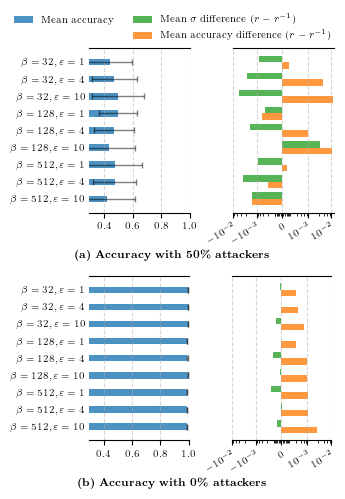

In [38]:
import itertools
from functools import partial

import numpy as np
from eiffel.analysis.metrics import load_df, load_metric, search_results
from matplotlib import pyplot as plt
from matplotlib.axes import Axes
from matplotlib.figure import Figure, SubFigure
from matplotlib.lines import Line2D
from matplotlib.ticker import NullFormatter, SymmetricalLogLocator

loadfn = partial(
    load_metric, dotpath="global.accuracy", attr="distributed", with_malicious=False
)

searchfn = partial(
    search_results,
    "hyperparams/results/",
    scenario="continuous-100",
    target="untargeted",
    datasets=".*cicids",
)

fig: Figure = plt.figure(figsize=figsize(1, 1.3), constrained_layout=True)
subfigures = fig.subfigures(nrows=2, ncols=1, hspace=0.1)

fig_handles = []
fig_labels = []
fig_titles = []

# C = 1 / np.log(10)
C = 1e-4
# functions for FuncScale: sgn(x) * log10(1 + abs(x / C))
logfuncs = (
    lambda x: np.sign(x) * np.log10(1 + np.abs(x / C)),
    lambda y: np.sign(y) * C * (10 ** np.abs(y) - 1),
)

for sub, dist in zip(subfigures, ("5-5", "10-0")):
    sub: SubFigure
    t = sub.suptitle(rf"Accuracy with {int(dist.split('-')[1])*10}\% attackers")
    fig_titles.append(t)

    left: Axes
    right: Axes
    left, right = sub.subplots(nrows=1, ncols=2, sharey=True)  # type: ignore

    y_tuples = sorted((itertools.product([32, 128, 512], [1, 4, 10])), reverse=True)
    y_labels = [rf"$\beta={b},\varepsilon={e}$" for b, e in y_tuples]
    y = np.arange(len(y_tuples))

    # Results for each tuple (batch_size, epochs)
    accuracies = []
    accuracies_err = []
    sigma_diffs = []
    sigma_diffs_err = []
    acc_diffs = []
    acc_diffs_err = []

    barw = 0.75 / 2  # width of each bar (width / nbars)

    for batch_size, epochs in y_tuples:
        df = load_df(
            searchfn(batch_size=batch_size, epochs=rf".*{epochs}x.*", distribution=dist)
        )

        # Round-wise mean and standard deviation
        accs = df.mean(axis=0)
        sigmas = df.std(axis=0)
        diffs = df.diff(axis=1).mean(axis=0)

        # Update the lists
        accuracies.append(accs.mean())
        accuracies_err.append(sigmas.mean())
        sigma_diffs.append(sigmas.diff().mean())
        sigma_diffs_err.append(sigmas.diff().std())
        acc_diffs.append(diffs.mean())
        acc_diffs_err.append(diffs.std())

    bar_kwargs: dict = dict(height=barw, alpha=0.8)
    err_kwargs: dict = dict(
        capsize=2, fmt="none", color="black", linestyle="--", alpha=0.5
    )

    # Plot the accuracies
    left.barh(
        y=y + barw / 2,
        width=accuracies,
        label="Mean accuracy",
        color="C0",
        **bar_kwargs,
    )
    left.errorbar(
        y=y + barw / 2,
        x=accuracies,
        xerr=accuracies_err,
        **err_kwargs,
    )

    # Plot the accuracy differences
    right.barh(
        y=y + 0 * barw,
        width=acc_diffs,
        label=r"Mean accuracy difference ($r-r^{-1}$)",
        color="C1",
        **bar_kwargs,
    )

    # Plot the standard deviation differences
    right.barh(
        y=y + 1 * barw,
        width=sigma_diffs,
        label=r"Mean $\sigma$ difference ($r-r^{-1}$)",
        color="C2",
        **bar_kwargs,
    )

    left.set_xlim(0.3, 1)
    left.set_xticks([0.4, 0.6, 0.8, 1])
    left.set_yticks(y + barw / 2)
    left.set_yticklabels(y_labels)

    right.set_xscale("function", functions=logfuncs)
    right.set_xticks([-1e-2, -1e-3, 0, 1e-3, 1e-2])
    right.set_xticklabels(
        [
            r"$-10^{-2}$",
            r"$-10^{-3}$",
            "0",
            r"$10^{-3}$",
            r"$10^{-2}$",
        ],
        rotation=30,
        ha="right",
        rotation_mode="anchor",
    )

    y_minor = SymmetricalLogLocator(
        base=10.0, subs=list(np.arange(0.1, 1, 0.2)), linthresh=1e-4
    )
    right.xaxis.set_minor_locator(y_minor)
    right.xaxis.set_minor_formatter(NullFormatter())


# Format and legend
abc = "abcdefghijklmnopqrstuvwxyz"
for i, sub in enumerate(subfigures):
    letter = abc[i]
    sub.suptitle(r"\textbf{%s}" % f"({letter}) {sub.get_suptitle()}", y=-0.0)
    for ax in sub.get_axes():
        ax.spines[["left", "right"]].set_visible(False)
        ax.yaxis.set_tick_params(length=0)
        ax.grid(axis="x", linestyle="--", alpha=0.5)

top = subfigures[0]
left, right = top.get_axes()
handles, labels = left.get_legend_handles_labels()
fig_handles.extend(handles + [Line2D([0], [0], color=None, linestyle="")])
fig_labels.extend(labels + [""])

handles, labels = right.get_legend_handles_labels()
fig_handles.extend(handles[::-1])
fig_labels.extend(labels[::-1])

lgd = fig.legend(
    fig_handles, fig_labels, loc="upper center", ncol=2, bbox_to_anchor=(0.5, 1.09)
)
tls = [f.get_suptitle() for f in subfigures]

fig.savefig(
    SAVEDIR + "hyperparams-continuous-bars.pdf",
    bbox_extra_artists=(lgd, *fig_titles),
    bbox_inches="tight",
)

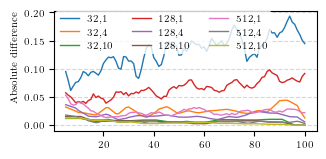

In [8]:
import itertools
from functools import partial

import pandas as pd
from eiffel.analysis.metrics import load_metric, search_results
from eiffel.analysis.plot import Plotable, scale

loadfn = partial(
    load_metric, attr="distributed", dotpath="global.accuracy", with_malicious=False
)

searchfn = partial(
    search_results,
    "hyperparams/results/",
    scenario="continuous-100",
    target="untargeted",
    datasets=".*cicids",
)

fig, left = plt.subplots(
    1,
    1,
    figsize=figsize(1, 0.5),
    tight_layout=True,
)

for i, (batch_size, epochs) in enumerate(itertools.product([32, 128, 512], [1, 4, 10])):
    plotables = scale(
        [
            Plotable(m, loadfn(m))
            for m in searchfn(
                batch_size=batch_size, epochs=rf".*{epochs}x.*", distribution="5-5"
            )
        ],
        100,
    )

    data = np.array([p.values for p in plotables])
    x = np.arange(1, data.shape[1] + 1)

    diffs = np.abs(data[:, 1:] - data[:, :-1])
    # duplicate the first column to keep the same shape
    diffs = np.concatenate([diffs[:, :1], diffs], axis=1)
    mean_diff = pd.DataFrame(np.mean(diffs, axis=0), x)
    smean_diff = mean_diff.rolling(window=5).mean()

    left.plot(x, smean_diff, label=f"{batch_size},{epochs}")


left.grid(axis="y", linestyle="--", alpha=0.5)
left.set_ylabel("Absolute difference", loc="top")

lgd = fig.legend(ncol=3, loc="upper center", bbox_to_anchor=(0.5, 0.94), frameon=True)
frame = lgd.get_frame()
frame.set_facecolor("white")
frame.set_linewidth(0)

fig.savefig(
    SAVEDIR + "hyperparams-accdiff.pdf",
    bbox_extra_artists=(lgd,),
    bbox_inches="tight",
)

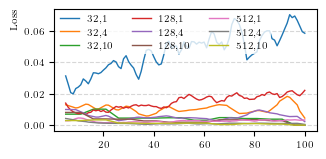

In [7]:
import itertools
from functools import partial

import pandas as pd
from eiffel.analysis.metrics import load_metric, search_results
from eiffel.analysis.plot import Plotable, scale

loadfn = partial(
    load_metric, attr="distributed", dotpath="global.loss", with_malicious=False
)

searchfn = partial(
    search_results,
    "hyperparams/results/",
    scenario="continuous-100",
    target="untargeted",
    datasets=".*cicids",
)

fig, left = plt.subplots(
    1,
    1,
    figsize=figsize(1, 0.5),
    tight_layout=True,
)

for i, (batch_size, epochs) in enumerate(itertools.product([32, 128, 512], [1, 4, 10])):
    plotables = scale(
        [
            Plotable(m, loadfn(m))
            for m in searchfn(
                batch_size=batch_size, epochs=rf".*{epochs}x.*", distribution="5-5"
            )
        ],
        100,
    )

    data = np.array([p.values for p in plotables])
    x = np.arange(1, data.shape[1] + 1)

    diffs = np.abs(data[:, 1:] - data[:, :-1])
    # duplicate the first column to keep the same shape
    diffs = np.concatenate([diffs[:, :1], diffs], axis=1)
    mean_diff = pd.DataFrame(np.mean(diffs, axis=0), x)
    smean_diff = mean_diff.rolling(window=5).mean()

    left.plot(x, smean_diff, label=f"{batch_size},{epochs}")


left.grid(axis="y", linestyle="--", alpha=0.5)
left.set_ylabel("Loss", loc="top")

lgd = fig.legend(ncol=3, loc="upper center", bbox_to_anchor=(0.5, 0.94), frameon=True)
frame = lgd.get_frame()
frame.set_facecolor("white")
frame.set_linewidth(0)

fig.savefig(
    SAVEDIR + "hyperparams-loss.pdf",
    bbox_extra_artists=(lgd,),
    bbox_inches="tight",
)

There seem to be no significant differences between the hyperparameter selections in terms of performance under constant attacks behavior.
However, we can clearly see that difference in terms of dispersion between the two scenarios (10-0 and 5-5). There are almost no dispersion in the 10-0 scenario, meaning that all runs converge to approximately the same result.

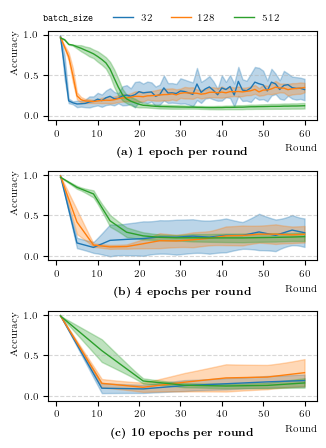

In [47]:
from functools import partial

from eiffel.analysis.metrics import load_metric, search_results
from eiffel.analysis.plot import Plotable, scale

loadfn = partial(
    load_metric, attr="distributed", dotpath="global.accuracy", with_malicious=False
)

searchfn = partial(
    search_results,
    "late/results/",
    scenario="late-3",
    target="untargeted",
    distribution="5-5",
    datasets=".*cicids",
)

fig, axs = plt.subplots(3, 1, figsize=figsize(1, 1.3), sharey=True, tight_layout=True)

for left, epochs in zip(axs, [1, 4, 10]):
    left: Axes
    left.set_title(f"{epochs} epoch{'s' if epochs > 1 else ''} per round")

    for i, batch_size in enumerate([32, 128, 512]):
        plotables_attack = scale(
            [
                Plotable(m, loadfn(m))
                for m in searchfn(batch_size=batch_size, epochs=rf".*{epochs}x.*")
            ],
            100,
        )

        data = np.array([p.values for p in plotables_attack])
        data = data[:, epochs : epochs + 60]  # start one round before the attack
        x = np.arange(1, data.shape[1] + 1)
        mean = np.mean(data, axis=0)
        sigma = np.std(data, axis=0)
        low_sigma = mean - sigma
        high_sigma = mean + sigma

        left.plot(x, mean, label=f"{batch_size}", color=f"C{i}")
        left.fill_between(x, low_sigma, high_sigma, alpha=0.3, color=f"C{i}")

abc = "abcdefghijklmnopqrstuvwxyz"
for i, left in enumerate(axs.ravel()):
    left.set_title(r"\textbf{" f"({abc[i]}) {left.get_title()}" r"}")
    left.grid(axis="y", linestyle="--", alpha=0.5)
    left.set_xlabel("Round", loc="right")
    left.set_ylabel("Accuracy", loc="top")

handles, labels = axs[0].get_legend_handles_labels()
handles.insert(0, plt.plot([], [], linestyle="")[0])  # fake handle
labels.insert(0, r"\texttt{batch\_size}")
lgd = fig.legend(
    handles, labels, ncol=4, loc="upper center", bbox_to_anchor=(0.45, 1.03)
)

fig.savefig(
    SAVEDIR + "hyperparams-late.pdf", bbox_extra_artists=(lgd,), bbox_inches="tight"
)

We align the curves so that they all start at the last known value before the attack starts, and measure the impact over 60 epochs (*i.e.*, 6, 24 or 60 rounds).

We observe a steeper drop in performance for smaller batches, while all other conditions are the same. 
Further, bigger batch sizes seem to have less variance.

Over time, the evolution in mean over time gets smaller, which means that the model tends to converge to a stable state.
Overall, the bigger the batch size and the number of local epochs, the more predictable the behavior is.
This is quite expected in terms of stability, and seems in phase with results from the literature.

### Conclusions

1. Some hyperparameters have an impact on the performance of the model poisoning, but it is not significant enough to be used as a defense mechanism. In average, the performance is the same.
2. A smaller batch size leads to a steeper drop in performance when poisoning starts. Therefore, in performance-constrained use cases (such as (I)IoT), the defense mechanisms need to react quicker to mitigate the impact of the attack. Round-based defense mechanisms (that apply the defense at the end of each round) might not be very affected, but reputation-based defenses (that account for the last interactions) might be impacted.
   Note: This is not a problem for Trust-FIDS, which targets CIDS in CSFL environments, and therefore is not performance-constrained.
3. The more local epochs per round, and the bigger the batch size, better the convergence of the model is. With a batch size of 512 and 10 local epochs, the models' variations diminish over time, leading to a more stable model. Note that this does not mean that the model is better, but that it is more stable. This is a good thing for the defense mechanisms, as it means that the attack is more predictable, and therefore easier to defend against.